#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys

plt.rcParams["figure.figsize"] = (18, 6)

In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import BinaryClassifierNet
from sources import load_dataset, parse_config, setup_model, default_config

## Constantes

In [4]:
EXPERIMENT_ID = 5
RUN_ID = '917994c5f11549968652b3939d636894'
OLD = False

EXP = f'/home/gaby/mlflow/mlruns/{EXPERIMENT_ID}/{RUN_ID}/artifacts/'
cfg = parse_config(EXP+'cfg_extended.yaml')
#cfg.training['dataset-file'] = '/home/gaby/These/src/Fundus/RotInvariance/3-Git/vessels.h5'
trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'
model = setup_model(cfg.model, old=OLD)

## Initialisation

In [5]:
net = BinaryClassifierNet(model=model)
state_dict = pl_load(EXP+'best-val-roc.ckpt'.format(25), map_location='cuda:0')['state_dict']
net.load_state_dict(state_dict)
net.eval().cuda()
None

In [6]:
for d in testD['MESSIDOR']:
    break

In [7]:
THETA = 24
x = torch.from_numpy(rotate(d['x'][0].numpy(), THETA)).cuda()

In [8]:
features = {}
def log_f(name):
    def hook(self, inputs, outputs):
        features[name] = outputs.detach().cpu().numpy()
    return hook
if OLD:
    net.model.conv2.relu.register_forward_hook(log_f('conv1'))
    net.model.conv4.relu.register_forward_hook(log_f('conv2'))
    net.model.conv6.relu.register_forward_hook(log_f('conv3'))
    net.model.conv8.relu.register_forward_hook(log_f('conv4'))
    net.model.conv10.relu.register_forward_hook(log_f('conv5'))
else:
    net.model.conv1[-1].relu.register_forward_hook(log_f('conv1'))
    net.model.conv2[-1].relu.register_forward_hook(log_f('conv2'))
    net.model.conv3[-1].relu.register_forward_hook(log_f('conv3'))
    net.model.conv4[-1].relu.register_forward_hook(log_f('conv4'))
    net.model.conv5[-1].relu.register_forward_hook(log_f('conv5'))

None

In [9]:
yhat = net(x)
yhat = yhat.detach().cpu().numpy()
yhat = unrotate(yhat, THETA)

RuntimeError: CUDA out of memory. Tried to allocate 316.00 MiB (GPU 0; 10.92 GiB total capacity; 8.60 GiB already allocated; 282.44 MiB free; 8.94 GiB reserved in total by PyTorch)

## Polar Spectral Power Density

In [ ]:
_ = spectral_power(yhat, plot=True)

In [ ]:
features = {k: unrotate(v, THETA) for k,v in features.items()}

In [ ]:
spe = spectral_power(features['conv1'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
if OLD:
    W = net.model.conv2.conv.weight.detach().cpu().numpy()
else:
    W = net.model.conv1[-1].conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
spe = spectral_power(features['conv2'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
if OLD:
    W = net.model.conv4.conv.weight.detach().cpu().numpy()
else:
    W = net.model.conv2[-1].conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
spe = spectral_power(features['conv3'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
spe = spectral_power(features['conv4'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[:, i]
    y = y/y.sum()
    x = np.arange(len(spe))
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

In [ ]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

grad = np.matmul(np.linspace(-1,1,3)[:,None],np.ones((1,3)))
noise = np.random.uniform(0,1,size=(100,100))
noise = gaussian_filter(noise, 3)
noise = rotate(noise, 24)
r = np.stack([convolve2d(_, grad) for _ in noise])
r = unrotate(r, 24)
spe = spectral_power(r, plot='sqr')

In [ ]:
spe = spectral_power(features['conv5'], plot=True, split='normed')
spe = spe / spe.sum(axis=0)
print(f"Conv5 | Equivariant features: {(spe[0]>=.5).sum()}/{spe.shape[1]} ({(spe[0]>=.5).sum()/spe.shape[1]}%)")

## Steerable Check

In [4]:
cfg = default_config()
cfg.model['steered'] = 'all'
cfg.model['padding'] = 'same'
cfg.model['upsample'] = 'nearest'
cfg.training['dataset-file'] = 'av.h5'

trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'

In [13]:
THETA = 12
np_thetas = np.linspace(0, 360, THETA, endpoint=False)
thetas = -torch.from_numpy(np_thetas)[:,None,None].cuda().float()*np.pi/180
cos_sin_thetas = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)
np_thetas = np_thetas[1:]

for d in trainD:
    break
x = torch.from_numpy(rotate(d['x'][0].numpy(), np_thetas)).cuda()
mask = d['mask'][0].numpy()

In [14]:
net = setup_model(cfg.model).cuda().eval()

**Absolute Alpha**

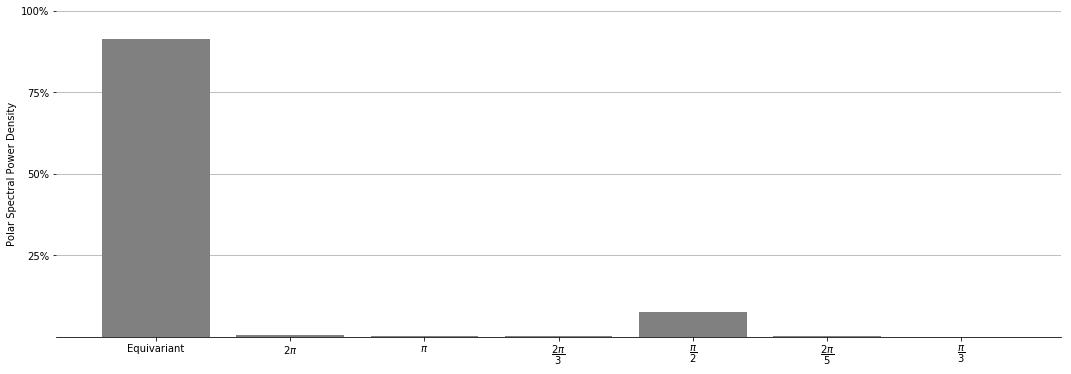

In [15]:
with torch.no_grad():
    yhat = net(x, thetas)
    yhat = clip_pad_center(yhat.detach().cpu(), mask.shape).numpy()
    yhat_unrotated = unrotate(yhat, np_thetas)
_ = spectral_power(yhat_unrotated, plot=True)

**Angle**

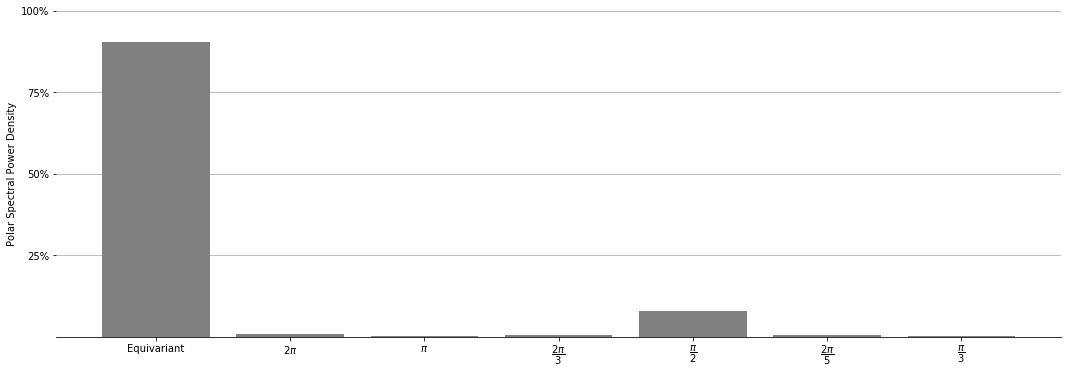

In [24]:
alphas = torch.from_numpy(rotate(d['angle'][0].numpy(), np_thetas)).cuda() + thetas
with torch.no_grad():
    yhat = net(x, alphas)
    yhat = clip_pad_center(yhat.detach().cpu(), mask.shape).numpy()
    yhat_unrotated = unrotate(yhat, np_thetas)
_ = spectral_power(yhat_unrotated, plot=True)

**Vectorial Normalized Field**

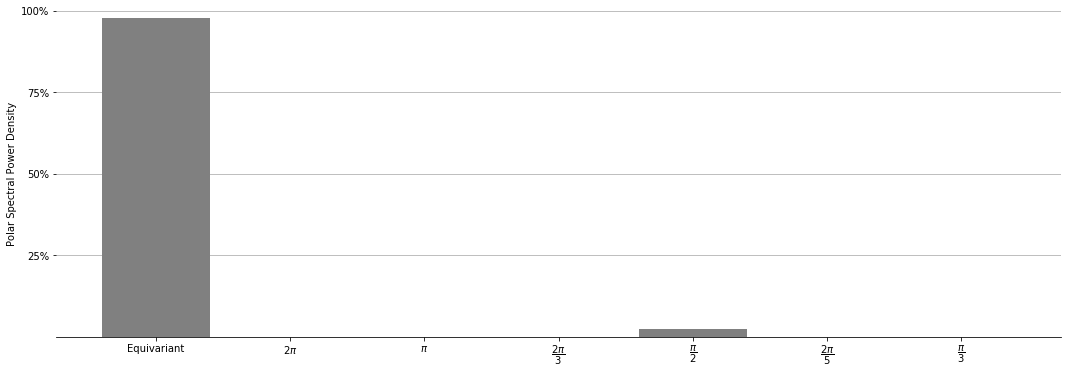

In [25]:
alphas_xy = torch.from_numpy(np.stack(rotate_vect(d['vec_norm'][0].numpy(), np_thetas),axis=1)).cuda().float()
with torch.no_grad():
    yhat = net(x, alphas_xy)
    yhat = clip_pad_center(yhat.detach().cpu(), mask.shape).numpy()
    yhat_unrotated = unrotate(yhat, np_thetas)
_ = spectral_power(yhat_unrotated, plot=True)

**Vectorial Field**

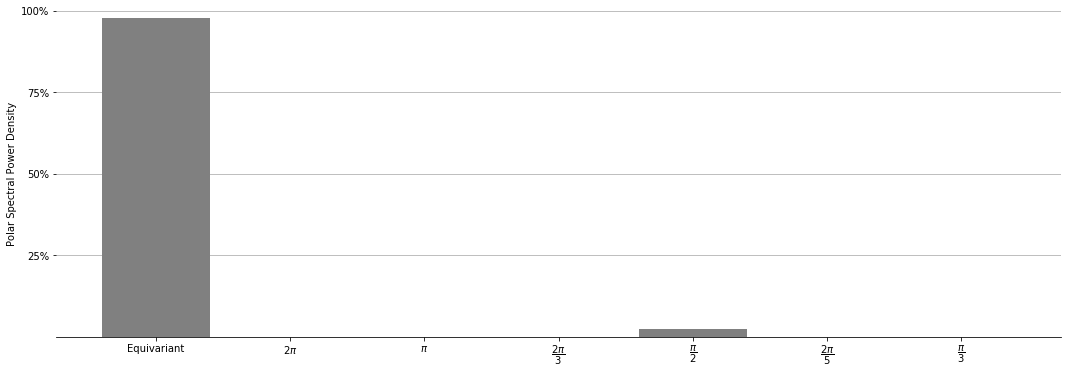

In [19]:
alphas_xy = torch.from_numpy(np.stack(rotate_vect(d['vec'][0].numpy(), np_thetas),axis=1)).cuda().float()
with torch.no_grad():
    yhat = net(x, alphas_xy)
    yhat = clip_pad_center(yhat.detach().cpu(), mask.shape).numpy()
    yhat_unrotated = unrotate(yhat, np_thetas)
_ = spectral_power(yhat_unrotated, plot=True)

In [11]:
diff = alphas-torch.atan2(alphas_xy[:,1],alphas_xy[:,0])
